In [1]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
assert tf.__version__ >= "2.0"

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from pathlib import Path
PROJECT_ROOT_DIR = Path().resolve().parent
CHAPTER_ID = "cnn"

IMAGES_PATH = Path(PROJECT_ROOT_DIR, "images", CHAPTER_ID)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    
    path = Path(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")


In [3]:
def crop(images):
    return images[150:220, 130:250]

In [4]:
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height , width, channels = images.shape

In [5]:
images.shape

(2, 427, 640, 3)

In [6]:
filters = np.zeros(shape = (7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0]  = 1
filters[3, :, :, 1] = 1

In [7]:
outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

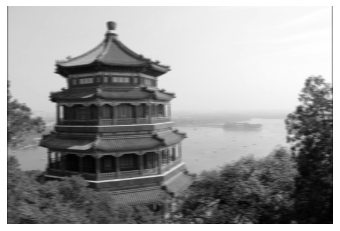

In [8]:
plt.imshow(outputs[0, :, :, 1], cmap = "gray")
plt.axis("off")
plt.show()

Saving figure china_original


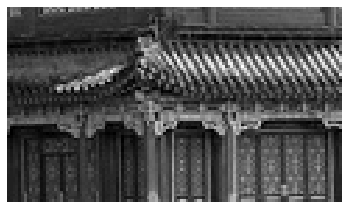

Saving figure china_vertical


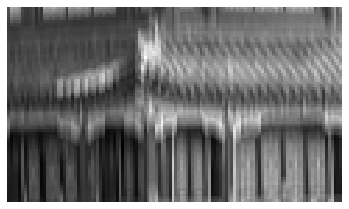

Saving figure china_horizontal


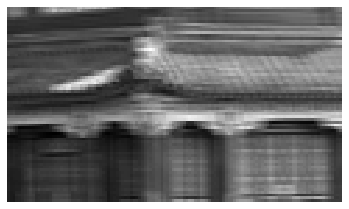

In [9]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

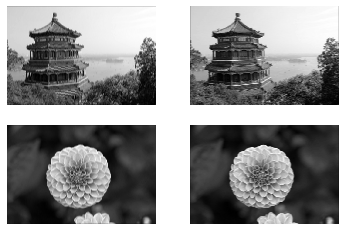

In [10]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Saving figure china_original


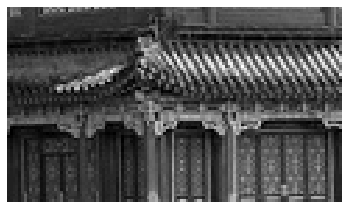

Saving figure china_vertical


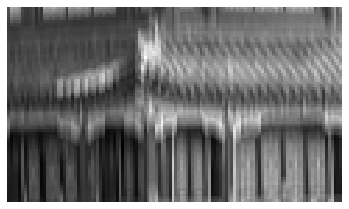

Saving figure china_horizontal


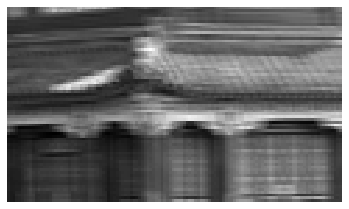

In [11]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

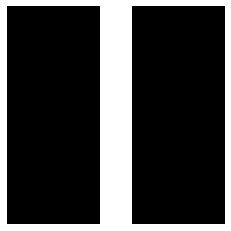

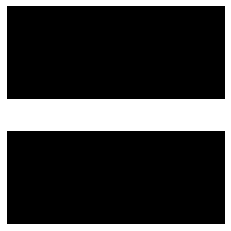

In [12]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [13]:
conv = keras.layers.Conv2D(filters = 32, kernel_size=32, strides= 1, padding="SAME", activation=tf.nn.relu)

In [14]:
outputs = conv(images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



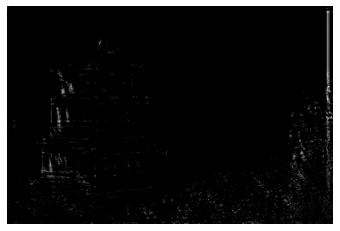

In [15]:
plt.imshow(outputs[0, :, :, 0], cmap = "gray")
plt.axis("off")
plt.show()

In [16]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [17]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

In [18]:
fig = plt.figure(figsize = (12, 8))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios =[2, 1])

<Figure size 864x576 with 0 Axes>

In [19]:
ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize = 14)
ax1.imshow(cropped_images[0])
ax1.axis("off")      


ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize = 14)
ax2.imshow(output[0])
ax2.axis("off")

save_fig("china_max_pooling")

plt.show()

Saving figure china_max_pooling


<Figure size 432x288 with 0 Axes>

Using a pretrained model

In [20]:
model = tf.keras.applications.ResNet50(weights="imagenet")

In [21]:
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

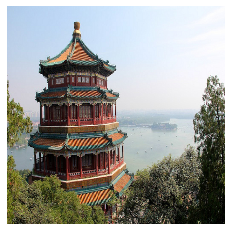

In [22]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


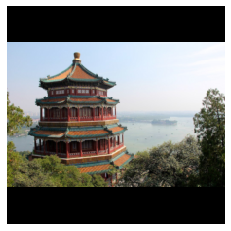

In [23]:
images_resized = tf.image.resize_with_pad(images, 224, 224,  antialias=True)
plot_color_image(images_resized[0])

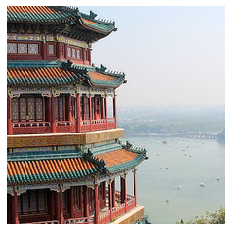

In [24]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

In [25]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_pred = model.predict(inputs)

In [26]:
Y_pred.shape

(2, 1000)

In [27]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_pred, top=5)
for image_index in range(len(images)):
    print(f"image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"\t{class_id} {name} ({y_proba * 100:.2f})")

image #0
	n03877845 palace (92.32)
	n03781244 monastery (5.34)
	n02825657 bell_cote (0.95)
	n02859443 boathouse (0.89)
	n04435653 tile_roof (0.27)
image #1
	n04522168 vase (38.44)
	n07930864 cup (8.86)
	n11939491 daisy (8.10)
	n01914609 sea_anemone (5.52)
	n03637318 lampshade (5.37)


Pretrained models for transfer learning

In [1]:
import tensorflow_datasets as tfds

In [5]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples  # 3670
class_names = info.features["label"].names  # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes  # 5


Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]

Dl Completed...:   0%|          | 0/1 [01:37<?, ? url/s]